# Two-Trader Optimizer, Unconstrained

In [35]:
""" Library of functions related to Fourier series
"""
import numpy as np
from scipy.integrate import quad
from typing import Callable, List, Tuple


def sin_coeff(func: Callable[[float], float], n: int,
              a: float = 0, b: float = 1) -> np.ndarray:
	""" Calculate coefficients of a sine series """
	coeffs = np.zeros(n)
	for i in range(1, n + 1):
		coeffs[i - 1] = quad(func, a, b, weight='sin', wvar=(i * np.pi))[0]
	return 2 * coeffs


def find_fourier_coefficients(functions: List[Callable[[float, float, float], float]],
                              kappa: float, lambda_: float, n: int, gamma: float = 1) -> List[np.ndarray]:
	all_coeffs = []
	for func in functions:
		coeffs = sin_coeff(lambda t: (func(t, kappa, lambda_) - t * gamma), n)
		all_coeffs.append(coeffs)
	return all_coeffs


def reconstruct_from_sin_with_loop(t: float, coeffs: np.ndarray, n: [int | None] = None) -> float:
	"""
    Reconstructs the function value at a given point `t` from a vector of sine coefficients.
	This is a slow version that uses loops.  It's replaced with a faster version

    :param t: The point at which to evaluate the reconstructed function.
    :param coeffs: An array of sine coefficients.
    :param n: The number of sine terms to use in the reconstruction. If None or greater than the length of `coeffs`,
              all coefficients are used.
    :return: The reconstructed function value at the point `t`.

    Notes:
    ------
    The function reconstructs the value by summing the sine series up to the `n`-th term.
    If `n` is not specified or exceeds the length of `coeffs`, it defaults to using all available coefficients.
    """
	reconstruction = 0  # Add the linear term t separately
	if n is None or n > len(coeffs):
		n = len(coeffs)
	for i in range(1, n + 1):
		reconstruction += coeffs[i - 1] * np.sin(i * np.pi * t)
	return reconstruction


def reconstruct_deriv_from_sin_with_loop(t: float, coeffs: np.ndarray, n: [int | None] = None, order: int = 1) -> float:
	"""
    Reconstructs the nth derivative of the function value at a given point `t` from a vector of sine coefficients.
	This is a slow version that uses loops.  It's replaced with a faster version

    :param t: The point at which to evaluate the reconstructed function.
    :param coeffs: An array of sine coefficients.
    :param n: The number of sine terms to use in the reconstruction. If None or greater than the length of `coeffs`,
              all coefficients are used.
    :param order: The order of the derivative to reconstruct.
    :return: The reconstructed nth derivative of the function value at the point `t`.

    Notes:
    ------
    The function reconstructs the nth derivative by summing the sine series up to the `n`-th term and applying the
    appropriate derivative formula for sine functions.
    If `n` is not specified or exceeds the length of `coeffs`, it defaults to using all available coefficients.
    """
	reconstruction = 0
	if n is None or n > len(coeffs):
		n = len(coeffs)
	for i in range(1, n + 1):
		reconstruction += coeffs[i - 1] * (i * np.pi) ** order * np.sin(i * np.pi * t + order * np.pi / 2)
	return reconstruction


def reconstruct_from_sin(t: float, coeffs: np.ndarray, n: [int | None] = None,
                         sin_values: [np.ndarray | None] = None) -> float:
	"""
    Reconstructs the function value at a given point `t` from a vector of sine coefficients.
	This is a slow version that uses loops.  It's replaced with a faster version

    :param t: The point at which to evaluate the reconstructed function.
    :param coeffs: An array of sine coefficients.
    :param n: The number of sine terms to use in the reconstruction. If None or greater than the length of `coeffs`,
              all coefficients are used.
    :param sin_values: Pre-computed values of sin(n * pi * t) as an array of the same size as coeffs for speedup
    :return: The reconstructed function value at the point `t`.

    Notes:
    ------
    The function reconstructs the value by summing the sine series up to the `n`-th term.
    If `n` is not specified or exceeds the length of `coeffs`, it defaults to using all available coefficients.
    """
	if n is None or n > len(coeffs):
		n = len(coeffs)
	i = np.arange(1, n + 1)
	if sin_values is None:
		sin_values = np.sin(i * np.pi * t)
	return coeffs[:n] @ sin_values


def reconstruct_deriv_from_sin(t: float, coeffs: np.ndarray, n: [int | None] = None, order: int = 1,
                               trig_values: [np.ndarray | None] = None) -> float:
	"""
    Reconstructs the nth derivative of the function value at a given point `t` from a vector of sine coefficients.
	This is a slow version that uses loops.  It's replaced with a faster version

    :param t: The point at which to evaluate the reconstructed function.
    :param coeffs: An array of sine coefficients.
    :param n: The number of sine terms to use in the reconstruction. If None or greater than the length of `coeffs`,
              all coefficients are used.
    :param order: The order of the derivative to reconstruct.
    :param trig_values: Pre-computed values of f(n * pi * t) as an array of the same size as coeffs for speedup
                        Where f = cos() for first deriv, -sin() for 2nd deriv etc.
                        It's the responsiblity of the user to ensure that the right values have been passed.
    :return: The reconstructed nth derivative of the function value at the point `t`.

    Notes:
    ------
    The function reconstructs the nth derivative by summing the sine series up to the `n`-th term and applying the
    appropriate derivative formula for sine functions.
    If `n` is not specified or exceeds the length of `coeffs`, it defaults to using all available coefficients.
    """
	if n is None or n > len(coeffs):
		n = len(coeffs)

	i = np.arange(1, n + 1)

	if trig_values is None:
		trig_values = np.sin(i * np.pi * t + order * np.pi / 2)
	return np.sum(coeffs[:n] * np.power(i * np.pi, order) * trig_values)

In [36]:
"""
Approximation of the cost function without integrals by using Fourier approximations for a(t), b(t)
"""
import numpy as np
from scipy.integrate import quad
from functools import reduce
from itertools import product


# integral of cos(n pi t) sin(n pi t) in closed form
def int_cos_sin_old(n, m):
	pi = np.pi
	if n != m:
		int_chk = (m - m * np.cos(m * pi) * np.cos(n * pi) - m * np.sin(m * pi) * np.sin(n * pi)) / (
				pi * (m ** 2 - n ** 2))
	else:
		int_chk = 0

	return int_chk


def int_cos_sin(n, m):
	pi = np.pi
	if n == m:
		ans = 0
	else:
		ans = (m - m * (-1) ** (m + n)) / (pi * (m ** 2 - n ** 2))

	return ans


def cost_fn_a_approx_old(a_n: np.ndarray, b_n: np.ndarray,
                     kappa: float, lambd: float, verbose=False):
	"""
	This computes the cost function of trader A from the formula in the
	real-world constraints paper.
	This approach avoids computing integrals.

	:param a_n: Coefficients a_n for n from 1 to N
	:param b_n: Coefficients b_n for n from 1 to N
	:param kappa: Constant κ (kappa) - permanent market impact
	:param lambd: Constant λ (lambda) - temporary market impact

	:return: The computed value of the expression I
	"""
	# Ensure input sequences are numpy arrays
	a_n = np.array(a_n, dtype=np.float64)
	b_n = np.array(b_n, dtype=np.float64)
	N = len(a_n)

	if len(b_n) != N:
		raise ValueError("Sequences a_n and b_n must be of the same length.")

	n = np.arange(1, N + 1)  # n from 1 to N

	# Compute the third term: kappa * [ (1 + lambd) / 2 + sum_{n odd} (2 * (b_n - a_n)) / (n * π) ]
	odd_indices = np.where(n % 2 == 1)[0]  # Indices where n is odd
	n_odd = n[odd_indices]
	a_n_odd = a_n[odd_indices]
	b_n_odd = b_n[odd_indices]
	pi = np.pi

	# I: \int_0^1 \dot{a} \dot{a} dt
	int_I = 1 + 0.5 * np.sum(n ** 2 * pi ** 2 * a_n ** 2)

	# II: \int_0^1 lambda \dot{b} \dot{a} dt
	int_II = lambd + (lambd / 2) * np.sum(n ** 2 * pi ** 2 * a_n * b_n)

	# III: \int_0^1 kappa \dot{a} a dt
	int_III = kappa / 2

	# Replaced the double loop with a faster version below
	# ans = 0
	# for n, a_co in enumerate(a_n, start=1):
	# 	for m, b_co in enumerate(b_n, start=1):
	# 		ans += a_co * b_co * n * pi * int_cos_sin(n, m)

	ans = reduce(
		lambda acc, x: acc + x[0] * x[1] * x[2] * pi * int_cos_sin(x[2], x[3]),
		((a_co, b_co, n, m) for n, a_co in enumerate(a_n, start=1) for m, b_co in enumerate(b_n, start=1)),
		0
	)

	iv4 = kappa * lambd * ans

	int_IV_1 = kappa * lambd * 0.5
	int_IV_2 = ((2 * lambd * kappa) / pi) * np.sum(b_n_odd / n_odd)
	int_IV_3 = -((2 * lambd * kappa) / pi) * np.sum(a_n_odd / n_odd)
	int_IV_4 = iv4

	int_IV = int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4
	integral = int_I + int_II + int_III + int_IV

	if verbose:
		print("APPROX TOTAL COST FUNCTION FROM APPROX FORMULA:")
		print("int_I: ", int_I)
		print("int_II: ", int_II)
		print("int_III: ", int_III)
		print("int_IV: ", int_IV)
		print("\tint_0^1 lambda kappa t dt: ", int_IV_1)
		print("\tint_0^1 lambda kappa (b(t)-t) dt: ", int_IV_2)
		print("\tint_0^1 lambda kappa t * (a'(t)-1) dt: ", int_IV_3)
		print("\tint_0^1 lambda kappa (b(t) - 1)*(a'(t) - 1) dt: ", int_IV_4)
		print("\tTotal of components: ", int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4)

		print("Loss function approximation formula: ", integral)

	return int_I + int_II + int_III + int_IV


def cost_fn_a_approx(a_n, b_n, kappa, lambd, verbose=False):
	"""
		This computes the cost function of trader A from the formula in the
		real-world constraints paper.
		This approach avoids computing integrals.

		:param a_n: Coefficients a_n for n from 1 to N
		:param b_n: Coefficients b_n for n from 1 to N
		:param kappa: Constant κ (kappa) - permanent market impact
		:param lambd: Constant λ (lambda) - temporary market impact

		:return: The computed value of the expression I
		"""
	# Ensure input sequences are numpy arrays
	a_n = np.array(a_n, dtype=np.float64)
	b_n = np.array(b_n, dtype=np.float64)
	n_coeffs = len(a_n)

	if len(b_n) != n_coeffs:
		raise ValueError("Sequences a_n and b_n must be of the same length.")

	pi = np.pi
	n = np.arange(1, n_coeffs + 1)

	# Calculate individual terms
	t1 = (2 + kappa) * (1 + lambd) / 2

	t2 = pi ** 2 / 2 * sum(i ** 2 * (a_n[i - 1] ** 2 + lambd * a_n[i - 1] * b_n[i - 1]) for i in n)

	t3 = 2 * kappa * lambd / pi * sum((b_n[i - 1] - a_n[i - 1]) / i for i in n if i % 2 == 1)

	t4 = 2 * kappa * sum((a_n[i - 1] + lambd * b_n[i - 1]) * a_n[j - 1] * i * j / (i * i - j * j)
	                     for i in n for j in n if (i + j) % 2 == 1)

	total_loss  = t1 + t2 + t3 + t4
	if verbose:
		print("APPROX TOTAL COST FUNCTION FROM APPROX FORMULA:")
		print("int_I: ", t1)
		print("int_II: ", t2)
		print("int_III: ", t3)
		print("int_IV: ", t4)

		print("Loss function approximation formula: ", total_loss)

	return total_loss


def cost_fn_b_approx(a_n, b_n, kappa, lambd, verbose=False):
	"""
		This computes the cost function of trader B from the formula in the
		real-world constraints paper.
		This approach avoids computing integrals.

		:param a_n: Coefficients a_n for n from 1 to N
		:param b_n: Coefficients b_n for n from 1 to N
		:param kappa: Constant κ (kappa) - permanent market impact
		:param lambd: Constant λ (lambda) - temporary market impact

		:return: The computed value of the expression I
		"""
	# Ensure input sequences are numpy arrays
	a_n = np.array(a_n, dtype=np.float64)
	b_n = np.array(b_n, dtype=np.float64)
	n_coeffs = len(a_n)

	if len(b_n) != n_coeffs:
		raise ValueError("Sequences a_n and b_n must be of the same length.")

	pi = np.pi
	n = np.arange(1, n_coeffs + 1)

	# Calculate individual terms
	t1 = (2 + kappa) * (1 + lambd) / 2

	t2 = pi ** 2 / 2 * sum(i ** 2 * (a_n[i - 1] * b_n[i - 1] + lambd * b_n[i - 1] ** 2) for i in n)

	t3 = 2 * kappa / pi * sum((a_n[i - 1] - b_n[i - 1]) / i for i in n if i % 2 == 1)

	t4 = 2 * kappa * sum((a_n[i - 1] + lambd * b_n[i - 1]) * b_n[j - 1] * i * j / (i * i - j * j)
	                     for i in n for j in n if (i + j) % 2 == 1)

	total_loss = lambd * (t1 + t2 + t3 + t4)
	if verbose:
		print("APPROX TOTAL COST FUNCTION FROM APPROX FORMULA:")
		print("int_I: ", t1)
		print("int_II: ", t2)
		print("int_III: ", t3)
		print("int_IV: ", t4)

		print("Loss function approximation formula: ", total_loss)

	return total_loss


# Exact cost computation function
def compute_integral_loss_function_direct(a_func, b_func, a_func_dot, b_func_dot, kappa, lambd):
	"""
	This computes the intgral of the loss function directly by integrating the
	functions of the trading strategies and their derivatives.

	WARNING: the derivatives of the functions are not che'cked for correctness.|
	"""

	# I: \int_0^1 \dot{a} \dot{a} dt
	def integrand_I(t):
		a_dot = a_func_dot(t, kappa, lambd)
		return a_dot * a_dot

	# II: \int_0^1 lambda \dot{b} \dot{a} dt
	def integrand_II(t):
		a_dot = a_func_dot(t, kappa, lambd)
		b_dot = b_func_dot(t, kappa, lambd)
		return lambd * b_dot * a_dot

	# III: \int_0^1 kappa a \dot{a} dt
	def integrand_III(t):
		a_dot = a_func_dot(t, kappa, lambd)
		return kappa * a_func(t, kappa, lambd) * a_dot

	# IV: \int_0^1 kappa lambda b \dot{a} dt
	def integrand_IV(t):
		a_dot = a_func_dot(t, kappa, lambd)
		return kappa * lambd * b_func(t, kappa, lambd) * a_dot

	int_I, _ = quad(integrand_I, 0, 1)
	int_II, _ = quad(integrand_II, 0, 1)
	int_III, _ = quad(integrand_III, 0, 1)
	int_IV, _ = quad(integrand_IV, 0, 1)

	integral = int_I + int_II + int_III + int_IV

	# Dissection of integral IV into four components

	def t_fn(t):
		return lambd * kappa * t

	def int_IV_component2(t):
		b_t = b_func(t, kappa, lambd)
		return lambd * kappa * (b_t - t)

	def int_IV_component3(t):
		a_dot_t = a_func_dot(t, kappa, lambd)
		return lambd * kappa * t * (a_dot_t - 1)

	#  return lambd * kappa * (a_dot_t - 1) * (b_t - 1)
	def int_IV_component4(t):
		a_dot_t = a_func_dot(t, kappa, lambd)
		b_t = b_func(t, kappa, lambd)
		return lambd * kappa * (b_t - t) * (a_dot_t - 1)

	int_IV_1, _ = quad(t_fn, 0, 1, limit=100)
	int_IV_2, _ = quad(int_IV_component2, 0, 1, limit=100)
	int_IV_3, _ = quad(int_IV_component3, 0, 1, limit=100)
	int_IV_4, _ = quad(int_IV_component4, 0, 1, limit=100)

	print("INTEGRATION OF LOSS FUNCTION FROM ORIGINAL FUNCTIONS")
	print("int_I: ", int_I)
	print("int_II: ", int_II)
	print("int_III: ", int_III)
	print("int_IV: ", int_IV)
	print("\tint_0^1 lambda kappa t dt: ", int_IV_1)
	print("\tint_0^1 lambda kappa (b(t)-t) dt: ", int_IV_2)
	print("\tint_0^1 lambda kappa t * (a'(t)-1) dt: ", int_IV_3)
	print("\tint_0^1 lambda kappa (b(t) - 1)*(a'(t) - 1) dt: ", int_IV_4)
	print("\tTotal of components: ", int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4)

	print("Exact integral of loss function: ", integral)

	return integral


def fourier_integral_cost_fn(a_coeffs, b_coeffs, kappa, lambd):
	"""
	Compute the integral I = ∫₀¹ [ (a_dot + λ b_dot) a_dot + kappa (a + λ b) a_dot ] dt

	where each of a, b, a_dot, b_dot is formed using the coefficients passed in:

	a(t) = t + sum a_n sin(n pi t)
	b(t) = t + sum b_n sin(n pi t)
	a_dot(t) = 1 + sum a_n n pi cos(n pi t)
	b_dot(t) = 1 + sum b_n n pi cos(n pi t)

	Integral components:

	Int_IV: \int_0^1

	Purpose:

	Allows us to check if integrating the loss function formed from the Fourier approximations of
	the strategies and their derivatives yields the same result as integrating the loss function
	itself.

	Parameters:
	a_coeffs (list or array): Coefficients aₙ for n = 1 to N
	b_coeffs (list or array): Coefficients bₙ for n = 1 to N
	lambd (float): Constant λ
	kappa (float): Constant κ (not used in this integral but included as per the request)

	Returns:
	float: The computed value of the integral I
	"""
	# Ensure coefficients are numpy arrays
	a_coeffs = np.array(a_coeffs, dtype=np.float64)
	b_coeffs = np.array(b_coeffs, dtype=np.float64)
	N = len(a_coeffs)

	if len(b_coeffs) != N:
		raise ValueError("Sequences a_coeffs and b_coeffs must be of the same length.")

	pi = np.pi

	# Define the functions a(t), b(t), a_dot(t), b_dot(t)
	def a(t):
		n = np.arange(1, N + 1)  # 1-based indexing
		terms = a_coeffs * np.sin(n * pi * t)
		return t + np.sum(terms)

	def b(t):
		n = np.arange(1, N + 1)
		terms = b_coeffs * np.sin(n * pi * t)
		return t + np.sum(terms)

	def a_dot(t):
		n = np.arange(1, N + 1)
		terms = a_coeffs * n * pi * np.cos(n * pi * t)
		return 1 + np.sum(terms)

	def b_dot(t):
		n = np.arange(1, N + 1)
		terms = b_coeffs * n * pi * np.cos(n * pi * t)
		return 1 + np.sum(terms)

	def a_b_dot(t):
		n = np.arange(1, N + 1)
		m = np.arange(1, N + 1)
		terms_b = b_coeffs * np.sin(m * pi * t)
		terms_a_dot = a_coeffs * n * pi * np.cos(n * pi * t)
		return terms_b * terms_a_dot

	# Components of the loss function

	# a'(t) * a'(t) (temporary impact)
	def int_adot_adot(t):
		a_t = a(t)
		b_t = b(t)
		a_dot_t = a_dot(t)
		b_dot_t = b_dot(t)
		return a_dot_t * a_dot_t

	# lambda b'(t) * a'(t) (temporary impact)
	def int_adot_lam_bdot(t):
		a_dot_t = a_dot(t)
		b_dot_t = b_dot(t)
		return lambd * b_dot_t * a_dot_t

	def int_kappa_a_a_dot(t):
		a_t = a(t)
		b_t = b(t)
		a_dot_t = a_dot(t)
		b_dot_t = b_dot(t)
		return kappa * a_t * a_dot_t

	# kappa * lambda * b(t) * a'(t)
	def int_kappa_lambd_b_a_dot(t):
		b_t = b(t)
		a_dot_t = a_dot(t)
		return kappa * lambd * b_t * a_dot_t

	int_I, error = quad(int_adot_adot, 0, 1, limit=100)
	int_II, error = quad(int_adot_lam_bdot, 0, 1, limit=100)
	int_III, error = quad(int_kappa_a_a_dot, 0, 1, limit=100)
	int_IV, error = quad(int_kappa_lambd_b_a_dot, 0, 1, limit=100)

	# Dissection of integral IV into four components

	def t_fn(t):
		return lambd * kappa * t

	def int_IV_component2(t):
		b_t = b(t)
		return lambd * kappa * (b_t - t)

	int_IV_2, _ = quad(int_IV_component2, 0, 1, limit=100)

	def int_IV_component3(t):
		a_dot_t = a_dot(t)
		return lambd * kappa * t * (a_dot_t - 1)

	def int_IV_component4(t):
		a_dot_t = a_dot(t)
		b_t = b(t)
		return lambd * kappa * (a_dot_t - 1) * (b_t - t)

	int_IV_1, _ = quad(t_fn, 0, 1, limit=100)
	int_IV_2, _ = quad(int_IV_component2, 0, 1, limit=100)
	int_IV_3, _ = quad(int_IV_component3, 0, 1, limit=100)
	int_IV_4, _ = quad(int_IV_component4, 0, 1, limit=100)

	integral = int_I + int_II + int_III + int_IV

	print("FOURIER INTEGRAL VALUES")
	print("int_I (int_0^1 a'(t) * a'(t) dt): ", int_I)
	print("int_II: (int_0^1 lambda a'(t) * b'(t) dt): ", int_II)
	print("int_III: (int_0^1 kappa a(t) * a'(t) dt): ", int_III)
	print("int_IV: (int_0^1 kappa * lambda * b(t) * a'(t) dt): ", int_IV)
	print("\tint_0^1 lambda kappa t dt: ", int_IV_1)
	print("\tint_0^1 lambda kappa b(t) dt: ", int_IV_2)
	print("\tint_0^1 lambda kappa t * a'(t) dt: ", int_IV_3)
	print("\tint_0^1 lambda kappa (a'(t)-1)(b(t)-t) dt: ", int_IV_4)
	print("\tTotal of components: ", int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4)
	print("Integral of the loss function computed from Fourier approximations:", integral)

	return integral


def compute_sine_series_for_functions(a_func, b_func, kappa, lambd, N):
	"""
	Compute the sine series coefficients a_n and b_n for functions a_func and b_func.

	Parameters:
	a_func: function(t, lambd, kappa, N)
		The function a_func(t, lambd, kappa, N) to be expanded.
	b_func: function(t, lambd, kappa, N)
		The function b_func(t, lambd, kappa, N) to be expanded.
	lambd: float
		Parameter lambda.
	kappa: float
		Parameter kappa.
	N: int
		Number of terms in the series.

	Returns:
	a_coeffs: numpy array
		The sine series coefficients for a_func.
	b_coeffs: numpy array
		The sine series coefficients for b_func.
	"""
	pi = np.pi
	a_coeffs = np.zeros(N)
	b_coeffs = np.zeros(N)

	for n in range(1, N + 1):
		# Compute coefficients for a_func
		def integrand_a(t):
			return 2 * (a_func(t, kappa, lambd) - t) * np.sin(n * pi * t)

		coeff_a, _ = quad(integrand_a, 0, 1)
		a_coeffs[n - 1] = coeff_a

		# Compute coefficients for b_func
		def integrand_b(t):
			return 2 * (b_func(t, kappa, lambd) - t) * np.sin(n * pi * t)

		coeff_b, _ = quad(integrand_b, 0, 1)
		b_coeffs[n - 1] = coeff_b

	return a_coeffs, b_coeffs


# Example functions that satisfy f(0) = 0 and f(1) = 1
def a_func(t, kappa, lambd):
	# Example function depending on lambda and kappa
	# Satisfies boundary conditions f(0) = 0, f(1) = 1
	return t ** 2 + lambd * np.sin(np.pi * t)


# Derivative of a_func (WARNING: there is no check to see if this is it!)
def a_func_dot(t, kappa, lambd):
	return 2 * t + np.pi * lambd * np.cos(np.pi * t)


def b_func(t, kappa, lambd):
	# Another example function depending on lambda and kappa
	# Satisfies boundary conditions f(0) = 0, f(1) = 1
	return t ** 3 + kappa * np.sin(2 * np.pi * t)


# Derivative of b_func (WARNING: there is no check to see if this is it!)
def b_func_dot(t, kappa, lambd):
	# Another example function depending on lambda and kappa
	# Satisfies boundary conditions f(0) = 0, f(1) = 1
	return 3 * t ** 2 + 2 * np.pi * kappa * np.cos(2 * np.pi * t)

<>:283: SyntaxWarning: invalid escape sequence '\i'
<>:283: SyntaxWarning: invalid escape sequence '\i'
C:\Users\vragu\AppData\Local\Temp\ipykernel_121564\3434199214.py:283: SyntaxWarning: invalid escape sequence '\i'
  """


In [37]:
# Investor Trading Schedules - eventually move into a separate files
import numpy as np


# ---------------------------------------------
# Risk-neutral
# ---------------------------------------------
def b_func_risk_neutral(t: float, params: dict) -> float:
    return params['gamma'] * t


def b_dot_func_risk_neutral(t: float, params: dict) -> float:
    return params['gamma']


# ---------------------------------------------
# Risk-averse
# ---------------------------------------------
def b_func_risk_averse(t: float, params: dict) -> float:
    gamma, sig = params['gamma'], params['sigma']
    return gamma * np.sinh(sig * t) / np.sinh(sig)


def b_dot_func_risk_averse(t: float, params: dict) -> float:
    gamma, sig = params['gamma'], params['sigma']
    return gamma * sig * np.cosh(sig * t) / np.sinh(sig)


# ---------------------------------------------
# Eager
# ---------------------------------------------
def b_func_eager(t: float, params: dict) -> float:
    gamma, sig = params['gamma'], params['sigma']
    return gamma * (np.exp(-sig * t) - 1) / (np.exp(-sig) - 1)


def b_dot_func_eager(t: float, params: dict) -> float:
    gamma, sig = params['gamma'], params['sigma']
    return -gamma * sig * np.exp(-sig * t) / (np.exp(-sig) - 1)


# ---------------------------------------------
# Parabolic
# ---------------------------------------------
def b_func_parabolic(t: float, params: dict) -> float:
    c, gamma = params['c'], params['gamma']
    return gamma * t + t * (t - c) / (1 - c)


def b_dot_func_parabolic(t: float, params: dict) -> float:
    c, gamma = params['c'], params['gamma']
    return gamma - (2 * t - c) / (1 - c)


# ---------------------------------------------
# Equilibrium
# ---------------------------------------------
def equil_2trader(t: float, params: dict) -> float:
    """  2-Trader equilibrium tradign schedules for a and b
         which one is chosen is controlled by parameter
         trader_a
    """
    kappa, lambd = params['kappa'], params['lambd']
    trader_a: bool = params['trader_a']
    exp = np.exp

    term1 = (1 - exp(-kappa * t / 3))
    term2 = exp(kappa / 3) * (exp(kappa / 3) + exp(2 * kappa / 3) + 1) * (lambd + 1)
    term3 = (lambd - 1) * exp(kappa * t / 3)
    term4 = (lambd - 1) * exp(2 * kappa * t / 3)
    term5 = (lambd - 1) * exp(kappa * t)
    term6 = 2 * (exp(kappa)-1)

    if trader_a:
        return - term1 * (-term2 + term3 + term4 + term5) / term6
    else:
        return term1 * (term2 + term3 + term4 + term5) / (term6 * lambd)


def equil_2trader_dot(t, params: dict):
    kappa, lambd = params['kappa'], params['lambd']
    trader_a: bool = params['trader_a']
    exp = np.exp

    term1 = exp(-kappa * t / 3) * kappa
    term2 = 3 * exp(4 * t * kappa / 3) * (lambd-1)
    term3 = (exp(kappa / 3) + exp(2*kappa / 3) + exp(kappa)) * (1+lambd)
    term4 = 6 * (-1 + exp(kappa))

    if trader_a:
        return term1 * (-term2 + term3) / term4
    else:
        return term1 * (term2 + term3) / (term4 * lambd)

In [41]:
"""  Numerically solving for the two-trader equilibrium
"""
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time
from typing import Any, List

lambd = 20
kappa = 10
gamma = 1

DEFAULT_N = 10
TOL_COEFFS = 1e-1
TOL_COSTS = 1e-1
N_PLOT_POINTS = 100

# Which trader we are solving for
TRADER_A, TRADER_B = range(2)


class State:

    def __init__(self, a_coeff: np.ndarray | None = None,
                 b_coeff: np.ndarray | None = None,
                 n: int | None = None, calc_costs: bool = True):
        if a_coeff is None and b_coeff is None:
            self.n = n if n is not None else DEFAULT_N
            self.a_coeff = np.zeros(self.n)
            self.b_coeff = np.zeros(self.n)
        else:
            n_a = len(a_coeff) if a_coeff is not None else 0
            n_b = len(b_coeff) if b_coeff is not None else 0
            self.n = max(n_a, n_b)

            self.a_coeff = a_coeff if a_coeff is not None else np.zeros(self.n)
            self.b_coeff = b_coeff if b_coeff is not None else np.zeros(self.n)

        assert len(self.a_coeff) == len(self.b_coeff), (
            f"Fourier coeff array length mismatch: len(a)={len(self.a_coeff)},",
            f"len(b)={len(self.b_coeff)}")

        if not calc_costs:
            self.a_cost = None
            self.b_cost = None
        else:
            self.a_cost = cost_fn_a_approx(self.a_coeff, self.b_coeff, kappa, lambd)
            self.b_cost = cost_fn_b_approx(self.a_coeff, self.b_coeff, kappa, lambd)

    def within_tol(self, other: "State") -> bool:
        """ Check if two states are within iteration tolerance """
        if not isinstance(other, State):
            return False

        # Calculate L2 norm for a_coeff and b_coeff
        a_coeff_diff = np.linalg.norm(self.a_coeff - other.a_coeff)
        b_coeff_diff = np.linalg.norm(self.b_coeff - other.b_coeff)

        # Calculate max absolute difference for a_cost and b_cost
        a_cost_diff = abs(self.a_cost - other.a_cost) if self.a_cost is not None and other.a_cost is not None else 0
        b_cost_diff = abs(self.b_cost - other.b_cost) if self.b_cost is not None and other.b_cost is not None else 0

        # Check if differences are within tolerances
        return (a_coeff_diff < TOL_COEFFS and b_coeff_diff < TOL_COEFFS and
                a_cost_diff < TOL_COSTS and b_cost_diff < TOL_COSTS)

    def __str__(self):
        s = ""
        s += f"a_coeff = {self.a_coeff}\n"
        s += f"b_coeff = {self.b_coeff}\n"
        if self.a_cost is not None:
            s += f"cost(a) = {self.a_cost:.4f},\t"
        else:
            s += f"cost(a) = None,\t"
        if self.b_cost is not None:
            s += f"cost(b) = {self.b_cost:.4f}"
        else:
            s += f"cost(b) = None"
        return s

    def update(self, solve: int) -> "State":
        """ Solve for the best response of one trader with respect to the other """

        if solve == TRADER_A:

            def cost_function(x, b_coeffs):
                return cost_fn_a_approx(x, b_coeffs, kappa, lambd)

            init_guess = self.a_coeff
            init_cost = cost_function(init_guess) if self.a_cost is None else self.a_cost
            args = (self.b_coeff,)
        else:
            def cost_function(x, a_coeffs):
                return cost_fn_b_approx(a_coeffs, x, kappa, lambd)

            init_guess = self.b_coeff
            init_cost = cost_function(init_guess) if self.b_cost is None else self.b_cost
            args = (self.a_coeff,)

        # Minimize the cost function
        start = time.time()
        result = minimize(cost_function, init_guess, args=(args))
        print(f"optimization time = {(time.time() - start):.4f}s")

        # Generate a new updated state
        if solve == TRADER_A:
            res_state = State(result.x, self.b_coeff, calc_costs=False)
            res_state.a_cost = cost_function(result.x, self.b_coeff)
            res_state.b_cost = self.b_cost
        else:
            res_state = State(self.a_coeff, result.x, calc_costs=False)
            res_state.a_cost = self.a_cost
            res_state.b_cost = cost_function(self.a_coeff, result.x)

        return res_state

    def check_v_theo(self, lambd: float, kappa: float, ax: Any) -> dict:
        """  Check the stolution against theoretical
        :param lambd:  scale of trader B
        :param kappa:  permanent impact
        :return: statistics: function values, norms of differences
        """

        # tf.equil_2trader() for t in not t_sample()..
        # calculate values using fr.reconstruct
        # compare and save

        t_values = np.linspace(0, 1, N_PLOT_POINTS)

        params = {'kappa': kappa, 'lambd': lambd, 'trader_a': True}
        a_theo = [equil_2trader(t, params) for t in t_values]

        params['trader_a'] = False
        b_theo = [equil_2trader(t, params) for t in t_values]

        a_approx = [reconstruct_from_sin(t, self.a_coeff) + gamma * t for t in t_values]
        b_approx = [reconstruct_from_sin(t, self.b_coeff) + gamma * t for t in t_values]

        # ax.plot(t_values, a_theo, s=20, label="a theo", color="green", linestyle="--", linewidth=3)
        # ax.plot(t_values, b_theo, s=20, label="b theo", color="skyblue", linestyle="--", linewidth=3)
        ax.scatter(t_values, a_theo, s=20, label="a theo", color="red")
        ax.scatter(t_values, b_theo, s=20, label="b theo", color="tomato")
        ax.plot(t_values, a_approx, label="a approx", color="green", linestyle="-")
        ax.plot(t_values, b_approx, label="b approx", color="blue", linestyle="-")
        ax.set_title(r"Theoretical and Approximated Trading Schedules")
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel('a(t), b(t)')
        ax.grid()

    @staticmethod
    def plot_convergence(iter_hist: List["State"], ax: Any) -> None:

        a_costs = [i.a_cost for i in iter_hist]
        b_costs = [i.b_cost for i in iter_hist]

        # Plot the points as circles
        ax.scatter(a_costs[1:-1], b_costs[1:-1], color='darkblue', s=20, label='(a,b) costs', alpha=0.4)

        # Connect the points with lines
        ax.plot(a_costs, b_costs, color='darkblue', linestyle='-', linewidth=1, alpha=0.4)
        # for i in range(len(a_costs) - 1):
        #     plt.arrow(a_costs[i], b_costs[i], a_costs[i + 1] - a_costs[i],
        #               b_costs[i + 1] - b_costs[i],
        #               head_width=0.03, head_length=0.04, fc='red', ec='red')

        # Highlight the starting and ending points
        plt.scatter(a_costs[0], b_costs[0], color='green', s=70, label='init guess')
        plt.scatter(a_costs[-1], b_costs[-1], color='red', s=70, label='result')

        # Label the starting and ending points
        plt.text(a_costs[0], b_costs[0], 'init guess', fontsize=12, ha='right',
                 color='black', weight='bold')
        plt.text(a_costs[-1], b_costs[-1], 'result', fontsize=12, ha='right',
                 color='black', weight='bold')

        ax.set_xlabel('Trader A cost')
        ax.set_ylabel('Trader B cost')
        ax.set_title('Trading Cost Convergence to Equilibrium - State Space Diagram')
        plt.legend()
        # ax.grid()


# Initialize a,b via the state class
state = State()
print("Initial State")
print(state)

# Start with no constraints
iter_hist = [state]

while True:
    print("\nStarting iteration:")
    state_a = state.update(solve=TRADER_A)
    print("New state A:")
    print(str(state_a))
    state = state_a.update(solve=TRADER_B)
    print("New State :")
    print(str(state))
    iter_hist.append(state_a)
    iter_hist.append(state)
    if iter_hist[-1].within_tol(iter_hist[-3]):
        break

print(f"\n-------------------------------\n"
      f"Converged after {len(iter_hist)//2} iterations:")
print("\nFinal State:")
print(state)

Initial State
a_coeff = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
b_coeff = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
cost(a) = 126.0000,	cost(b) = 2520.0000

Starting iteration:
optimization time = 0.0861s
New state A:
a_coeff = [ 1.29006137e+01  0.00000000e+00  4.77800513e-01 -1.97835195e-08
  1.03204877e-01 -1.70245652e-08  3.76110947e-02 -8.73316296e-09
  1.76963197e-02 -1.10325608e-08]
b_coeff = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
cost(a) = -707.1991,	cost(b) = 2520.0000
optimization time = 0.0596s
New State :
a_coeff = [ 1.29006137e+01  0.00000000e+00  4.77800513e-01 -1.97835195e-08
  1.03204877e-01 -1.70245652e-08  3.76110947e-02 -8.73316296e-09
  1.76963197e-02 -1.10325608e-08]
b_coeff = [-0.29026382  0.20168146 -0.01075052  0.02525552 -0.00232212  0.00751123
 -0.00084626  0.00319475 -0.00039817  0.00168685]
cost(a) = -707.1991,	cost(b) = 334415.1352

Starting iteration:
optimization time = 0.0435s
New state A:
a_coeff = [10.00553933 -3.83194804  1.44885469 -0.47985469  0.33275775 -0.14271351
  0.1239

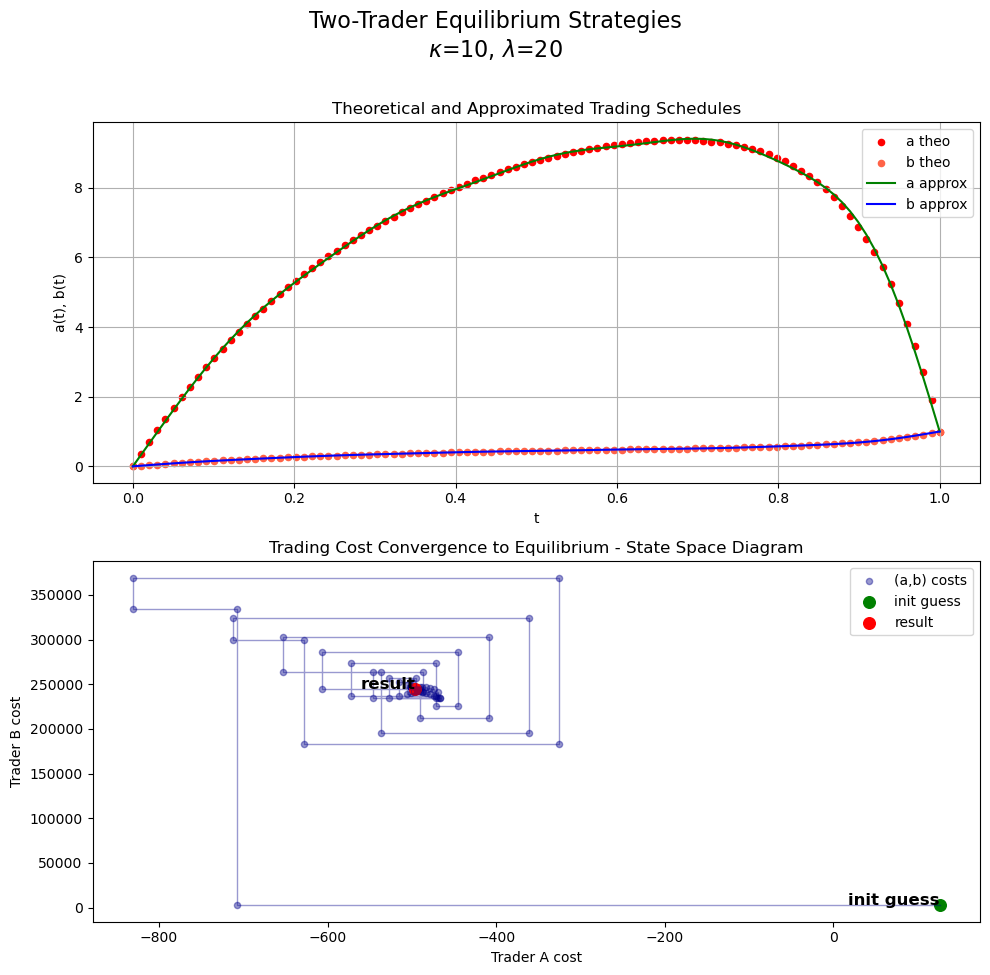

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
plt.suptitle("Two-Trader Equilibrium Strategies\n" +
             r"$\kappa$" + f"={kappa}, " + r"$\lambda$" + f"={lambd}", fontsize=16)
state.check_v_theo(lambd, kappa, axs[0])
state.plot_convergence(iter_hist, axs[1])

plt.tight_layout(rect=(0., 0.01, 1., 0.97))
plt.show()
